In [1092]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Dropout, Flatten, Activation, \
BatchNormalization, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import keras.applications.xception as xception

In [1093]:
# !pip install seaborn

### Storing the Waste Images

In [1136]:
# Identifying the different waste classes
categories_dict = {0: "paper", 1: "cardboard", 2: "plastic", 3: "metal", 4: "glass"}

# Path - location of data 
base_path ="garbage_classification/garbage_classification_subfolder/"

# Matching the image size for the xception model
# Side note - The training accuracy didn't increase with an increased image size
IMAGE_WIDTH = 220    
IMAGE_HEIGHT = 220
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

In [1137]:
# Lists to store the filenames and categories
categories, filenames = [], []

# Loop through and store the filenames and categories
for category in categories_dict: 
    dir_filenames = os.listdir(base_path + categories_dict[category])
    filenames = filenames + dir_filenames
    categories = categories + [category] * len(dir_filenames)

# Create a DataFrame with the filename and corresponding category  
file_category_df = pd.DataFrame({'filename': filenames, 'category': categories})
file_category_df.head()

,filename,category
0,paper283.jpg,0
1,paper297.jpg,0
2,paper526.jpg,0
3,paper240.jpg,0
4,paper254.jpg,0


In [1138]:
# Convert the file names for the organic images as they were previously downloaded/labelled with 'O_' instead of 
# 'organic' as the prefix 
file_category_df.loc[file_category_df["filename"].str.contains("O_"), 'filename'] = \
file_category_df.loc[file_category_df["filename"].str.contains("O_"), 'filename'].str.replace("O_", "organic")

file_category_df.loc[file_category_df["filename"].str.contains("organic")]

,filename,category


In [1139]:
file_category_df = file_category_df.drop(labels=range(8000, 14955), axis=0)
file_category_df.loc[file_category_df['filename'].str.contains("organic")]

In [1140]:
# Loop through and convert the filenames in the stored system folder too
dir_filenames = os.listdir(base_path + categories_dict[5])
convert = lambda x: x[0 : re.search("\d", x).start()].replace("O_", "organic") + x[re.search("\d", x).start():]
for file in dir_filenames: 
    os.rename(base_path + "organic/" + file, base_path + "organic/" + convert(file))

In [1141]:
# # Method name: add_class_name_prefix 
# # Parameters: 
#     # input_df - DataFrame containing the filenames and corresponding category
# # Output: DataFrame with converted values in the 'filenames' column
# # Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
# def add_prefix_to_filename(input_df):
#     input_df['filename'] = input_df['filename'].apply(lambda x: x[0:re.search("\d", x).start()] + '/' + x)
#     return input_df
# file_category_df = add_prefix_to_filename(file_category_df)

# Convert the filenames to add a prefix 
file_category_converted_col = file_category_df['filename'].apply(lambda x : x[0:re.search("\d", x).start()] + f'/{x}')
file_category_df['filename'] = file_category_converted_col

# Shuffle the dataframe
file_category_df = file_category_df.sample(frac=1).reset_index(drop=True)
print(file_category_df.info())
file_category_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390 entries, 0 to 2389
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2390 non-null   object
 1   category  2390 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.5+ KB
None


,filename,category
0,metal/metal54.jpg,3
1,glass/glass63.jpg,4
2,plastic/plastic166.jpg,2
3,metal/metal277.jpg,3
4,glass/glass469.jpg,4


<Figure size 1080x504 with 0 Axes>

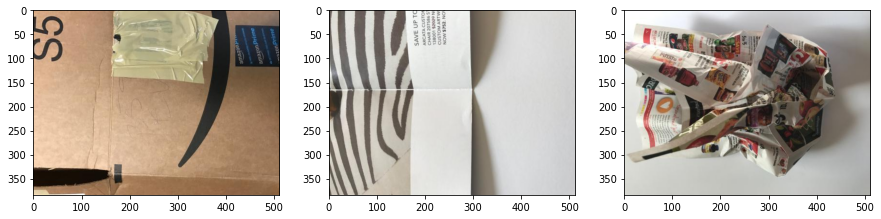

In [1142]:
# Generate multiple images from the DataFrame
plt.figure()
plt.rcParams["figure.figsize"] = [15.00, 7.00]
f, axarr = plt.subplots(1,3) 
for i in range(3):
    sample_image = file_category_df.iloc[random.randint(0, len(file_category_df) - 1)]
    selected_random_image = tf.keras.utils.load_img(base_path + sample_image['filename'])
    axarr[i].imshow(selected_random_image)

### Vizualizations

Text(0.5, 1.0, '# Images Per Class')

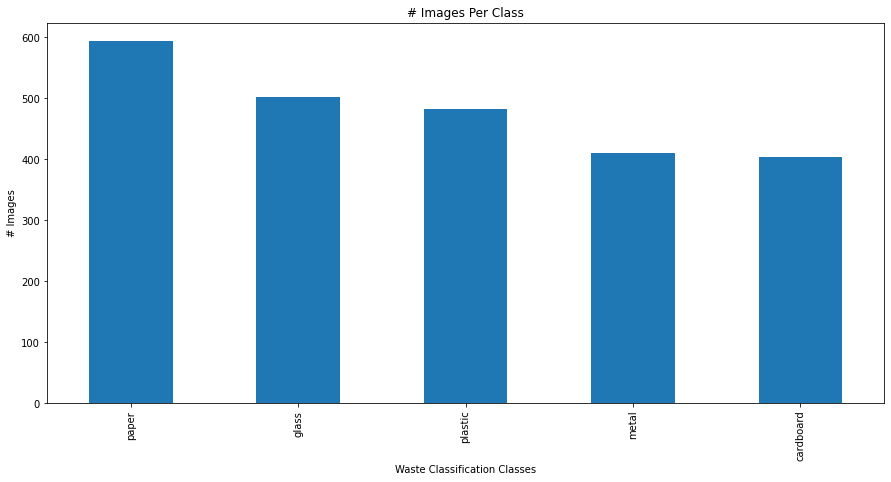

In [1143]:
# Plot the number of images per class 
df_visualization = file_category_df.copy()
df_visualization['category'] = df_visualization['category'].apply(lambda x : categories_dict[x])
df_visualization['category'].value_counts().plot.bar()
plt.xlabel("Waste Classification Classes")
plt.ylabel("# Images")
plt.title("# Images Per Class")

In [1144]:
# Plot the number of images per waste group (compost, recycling, trash)
# compost - organic 
# recycling - paper, plastic, metal, cardboard 
# waste - trash, glass (glass is kind of tricky, so to be safe, I am placing it in the waste category)
waste_recyc_com_categories = {0: "waste", 1: "recycling", 2: "compost"}
waste = ["trash", "glass"]
recycling = ["paper", "plastic", "metal", "cardboard"]
compost = ["organic"]

In [1145]:
# Method name: addWasteGroup 
# Parameters: 
    # row - DataFrame row containing the filenames and corresponding category for each image
# Output: Integer representing the key value of the corresponding waste group from the dictionary defined 
#         above named waste_recyc_com_categories
# Add the appropriate overarching waste group label to each image based on the lists defined in the previous cell 
def addWasteGroup(row): 
    row_filename = row['filename']
    prefix_end_index = re.search(r"\/", row_filename).start()
    filename_prefix = row_filename[:prefix_end_index]
    if filename_prefix in waste: 
        return 0
    elif filename_prefix in recycling: 
        return 1
    else: 
        return 2

In [1146]:
file_category_df['waste_group'] = file_category_df.apply(lambda row: addWasteGroup(row), axis=1)
file_category_df.head(10)

,filename,category,waste_group
0,metal/metal54.jpg,3,1
1,glass/glass63.jpg,4,0
2,plastic/plastic166.jpg,2,1
3,metal/metal277.jpg,3,1
4,glass/glass469.jpg,4,0
5,paper/paper132.jpg,0,1
6,paper/paper570.jpg,0,1
7,glass/glass134.jpg,4,0
8,cardboard/cardboard3.jpg,1,1
9,paper/paper403.jpg,0,1


Text(0.5, 1.0, '# Images Per Group')

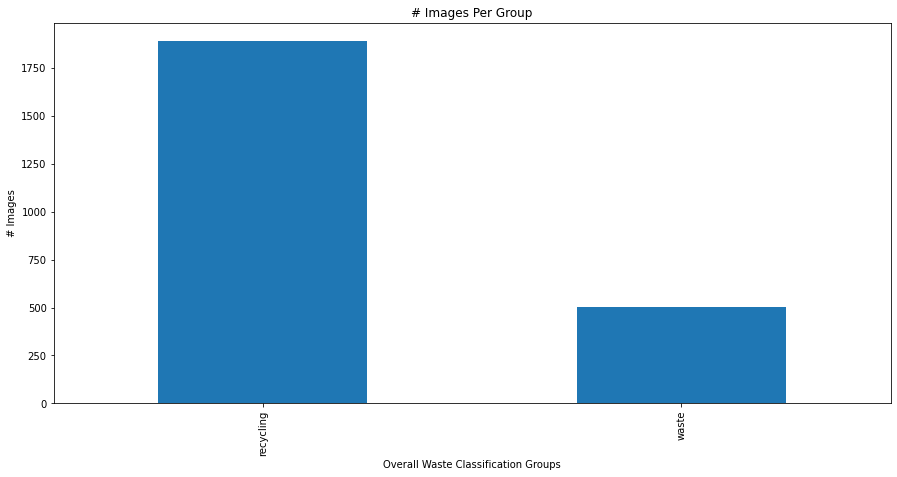

In [1147]:
# Plot the number of images per waste group 
df_visualization = file_category_df.copy()
df_visualization['waste_group'] = df_visualization['waste_group'].apply(lambda x : waste_recyc_com_categories[x])
df_visualization['waste_group'].value_counts().plot.bar()
plt.xlabel("Overall Waste Classification Groups")
plt.ylabel("# Images")
plt.title("# Images Per Group")

### Altering the Images 

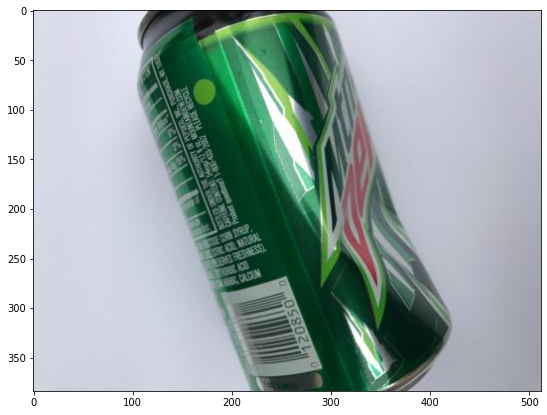

In [1148]:
random_img_ex = file_category_df.loc[3, 'filename']
img_ex = tf.keras.utils.load_img(base_path + "/" + random_img_ex)
plt.imshow(img_ex)

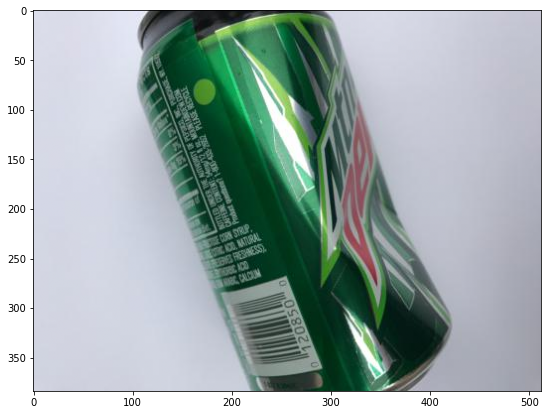

In [1149]:
# Normalization
np_img = np.array(img_ex)
norm_image = (np_img - np.min(np_img)) / (np.max(np_img) - np.min(np_img))
plt.imshow(norm_image)

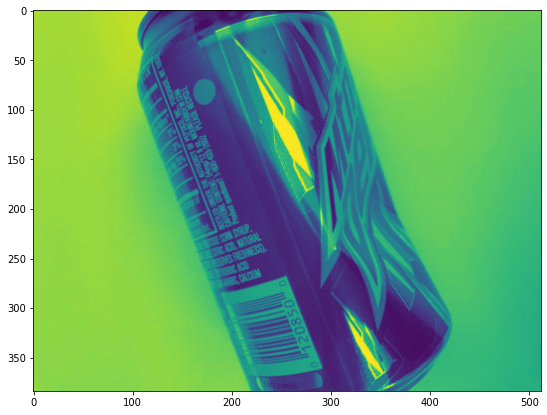

In [1150]:
# Gray Scale
plt.imshow(tf.image.rgb_to_grayscale(
    np.array(img_ex), name=None
))

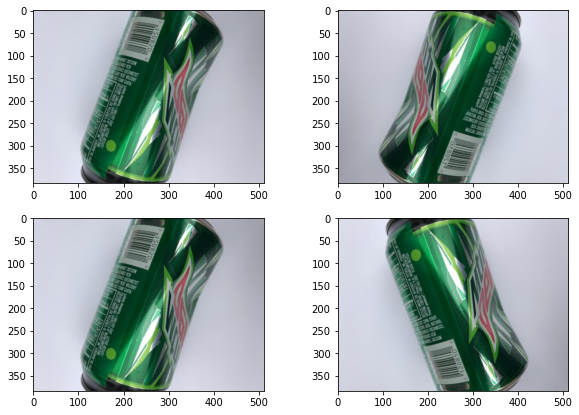

In [1151]:
# Flipping the image relative to x and y axis 
plt.figure(figsize=(10, 7))
for i in range(4): 
    ax = plt.subplot(2, 2, i + 1)
    if i % 2 == 0:
        plt.imshow(tf.image.random_flip_up_down(np_img))
    else: 
        plt.imshow(tf.image.random_flip_left_right(np_img))

### Model 

In [1152]:
## Becuase Pixel range in Images are between [0,255], To rescale an input in the [0, 255] range
# to be in the [0, 1] range, you would pass scale=1./255
resize_and_rescale = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
            tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [1153]:
data_augmentation = tf.keras.Sequential([
                            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                            tf.keras.layers.experimental.preprocessing.RandomRotation((-0.2, 0.3))
])

In [1154]:
# Defining the xception layer 
xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), \
                                   weights = 'imagenet')
# Not training the imported weights
for layer in xception_layer.layers:
    layer.trainable = False

# Compile/Build 
model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

# Preprocessing
def xception_layer_preprocessing(img):
  return xception.preprocess_input(img)
# model.add(resize_and_rescale)
# model.add(data_augmentation)
model.add(Lambda(xception_layer_preprocessing))

model.add(xception_layer)
model.add(Dropout(0.2))
# model.add(tf.keras.layers.Conv2D(32, 3, activation = 'softmax')),
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories_dict), activation='softmax')) 
# model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()


Model: "sequential_174"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_36 (Lambda)          (None, 220, 220, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_35  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_52 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 20,871,725
Trainable params: 10,245
Non-trainable params: 20,861,480
___________________________________

In [1155]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor = 'val_categorical_accuracy', \
                           mode = 'max', min_delta = 0.001, restore_best_weights = True)

In [1182]:
# Change the categories from numbers to names
file_category_df["category"] = file_category_df["category"].replace(categories_dict) 

# Split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(file_category_df, stratify=file_category_df['category'], test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, stratify=validate_df['category'],test_size=0.5, random_state=42)

# Reset the indices for all the different data sets 
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [1187]:
batch_size = 32
train_datagen = image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1, 
    horizontal_flip=True,
    vertical_flip = True
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 1912 validated image filenames belonging to 5 classes.


In [1188]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
#     y_col='waste_group',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 239 validated image filenames belonging to 5 classes.


In [1164]:
test_datagen = image.ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    batch_size=1,
    shuffle=False 
)

Found 239 validated image filenames belonging to 5 classes.


In [1189]:
len(train_df)//batch_size

59

In [1190]:
# Fit model to the training data 
EPOCHS = 15
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validate_df)//batch_size,
    steps_per_epoch=len(train_df)//batch_size,
    callbacks=[early_stop]
)

Epoch 1/15
59/59 [==============================] - 613s 10s/step - loss: 0.1952 - categorical_accuracy: 0.9362 - val_loss: 0.7676 - val_categorical_accuracy: 0.8125
Epoch 2/15
59/59 [==============================] - 2532s 43s/step - loss: 0.1020 - categorical_accuracy: 0.9665 - val_loss: 0.2166 - val_categorical_accuracy: 0.9375
Epoch 3/15
59/59 [==============================] - 583s 10s/step - loss: 0.0851 - categorical_accuracy: 0.9729 - val_loss: 0.2885 - val_categorical_accuracy: 0.9241
Epoch 4/15
59/59 [==============================] - 529s 9s/step - loss: 0.0787 - categorical_accuracy: 0.9729 - val_loss: 1.0028 - val_categorical_accuracy: 0.8214
Epoch 4: early stopping


In [1191]:
# Unfreeze the imported weights and fit the model again to the training data 
for layer in xception_layer.layers:
    layer.trainable = True

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_174"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_36 (Lambda)          (None, 220, 220, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_35  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_52 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
___________________________________

In [1192]:
model_data = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validate_df)//batch_size,
    steps_per_epoch=len(train_df)//batch_size,
    callbacks=[early_stop]
)

Epoch 1/15
59/59 [==============================] - 545s 9s/step - loss: 0.2273 - categorical_accuracy: 0.9298 - val_loss: 1.5673 - val_categorical_accuracy: 0.7500
Epoch 2/15
59/59 [==============================] - 716s 12s/step - loss: 0.1239 - categorical_accuracy: 0.9622 - val_loss: 0.7632 - val_categorical_accuracy: 0.8482
Epoch 3/15
59/59 [==============================] - 923s 16s/step - loss: 0.1277 - categorical_accuracy: 0.9617 - val_loss: 0.8688 - val_categorical_accuracy: 0.8214
Epoch 4/15
59/59 [==============================] - 1190s 20s/step - loss: 0.1334 - categorical_accuracy: 0.9601 - val_loss: 0.4655 - val_categorical_accuracy: 0.8839
Epoch 5/15
59/59 [==============================] - 6409s 110s/step - loss: 0.0620 - categorical_accuracy: 0.9793 - val_loss: 0.4721 - val_categorical_accuracy: 0.9062
Epoch 6/15
59/59 [==============================] - 1299s 22s/step - loss: 0.0830 - categorical_accuracy: 0.9777 - val_loss: 0.3622 - val_categorical_accuracy: 0.9152
E

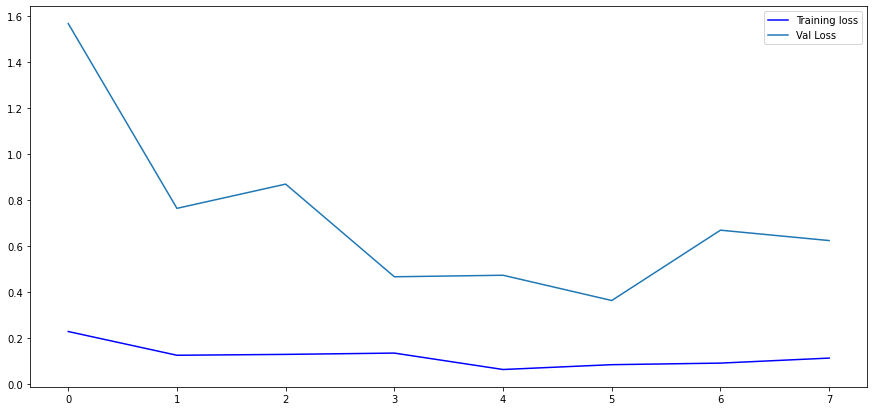

In [1193]:
# Plotting loss
plt.plot(model_data.history['loss'], color='b', label="Training loss")
plt.plot(model_data.history['val_loss'], label="Val Loss")
plt.legend()
plt.show()

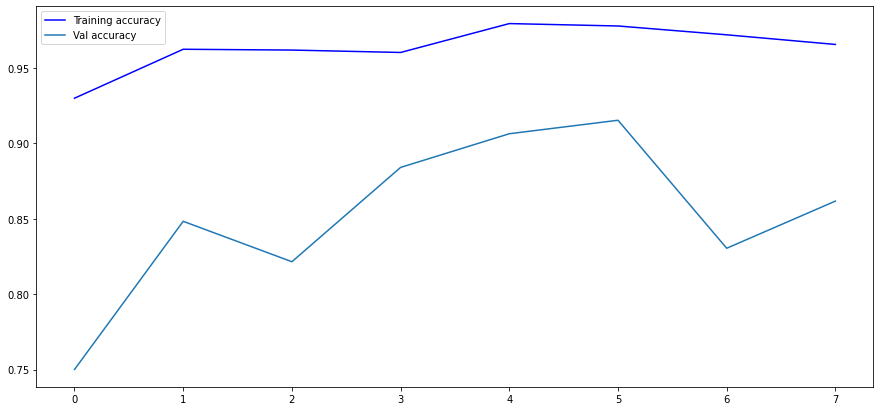

In [1194]:
# Plotting accuracy 
plt.plot(model_data.history['categorical_accuracy'], color='b', label="Training accuracy")
plt.plot(model_data.history['val_categorical_accuracy'], label="Val accuracy")
plt.legend()
plt.show()

In [1212]:
throwaway_variable, accuracy = model.evaluate(test_generator)

239/239 [==============================] - 39s 164ms/step - loss: 0.5596 - categorical_accuracy: 0.8870


In [1213]:
# Model's predictions 
gen_label_map = dict((num, category) for category, num in test_generator.class_indices.items())
test_generator.reset()
preds = model.predict(test_generator, len(test_generator.filenames))

# Category with the highest predicted probability
preds = preds.argmax(1)

239/239 [==============================] - 47s 196ms/step


In [1214]:
# Convert category number to corresponding category name
models_labels = dict((num, category) for category, num in train_generator.class_indices.items())
cat_preds = [models_labels[pred] for pred in preds]
labels = test_df['category'].to_numpy()

In [1215]:
print(classification_report(labels, cat_preds))

              precision    recall  f1-score   support

   cardboard       0.83      0.93      0.87        41
       glass       0.87      0.82      0.85        50
       metal       0.86      0.93      0.89        41
       paper       0.95      0.97      0.96        59
     plastic       0.90      0.79      0.84        48

    accuracy                           0.89       239
   macro avg       0.88      0.89      0.88       239
weighted avg       0.89      0.89      0.89       239

